# Numerische Methoden für Differentialgleichungen
## Aufgabenblatt 7
*gelöst von Stollmayer Max*

Für die Konvektionsgleichung

\begin{cases}
\begin{align*}
\partial_t u(x,t) + a\cdot\partial_x u(x,t) = 0,& \quad x\in D,\ t\ge 0 \\
u(x,0)=\sin(2\pi x),& \quad x\in D \\
u(0,t)=u(1,t),& \quad t\ge 0
\end{align*}
\end{cases}

mit konstantem Koeffizient $a = -1$ und $D = [0,1]$ ist das Upwind- und das Lax-Friedrichs-Verfahren zu implementieren. Dabei ist der Zeitschritt $k$ so zu wählen, dass die Stabilitätsbedingung $|a|\frac{k}{h} \le 1$ erfüllt ist.
Die Verfahren sind für 50 und 400 Gitterpunkte in Ortsrichtung mit der exakten Lösung zu den Zeiten $T=0.5$ und $T=1$ zu vergleichen.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Plot styling
from matplotlib import rcdefaults
rcdefaults()
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = [12.8, 7.2]
plt.rcParams["font.size"] = 12
plt.rcParams["axes.edgecolor"] = "white"
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.framealpha"] = 0.75
plt.rcParams["legend.facecolor"] = "white"
plt.rcParams["legend.edgecolor"] = "white"

In [2]:
def Upwind(a, u0, D, N, c=1):
    '''
    Solves the one-dimensional, linear, hyperbolic PDE u_t + a*u_x = 0
    with initial value function u0(x) and periodic boundary values
    using the Lax-Friedrichs method.
    
    returns 2D-array of function values
    
    a .... constant
    u0 ... intial value function in the x variable
    D .... [[a, b], [c, d]] array of corners of the square
    N .... number of discretization steps for in x direction
    c .... scaling factor for discretization in t direction,
           0 < c <= 1 satisfies Courant-Friedrichs-Lewy stability condition
    '''
    
    D = np.array(D)
    h = (D[0,1] - D[0,0]) / N
    k = c * h / np.abs(a) if a != 0 else (D[1,1] - D[1,0])
    M = int((D[1,1] - D[1,0]) / k)
    
    u = np.zeros((M+1, N+1))
    u[0] = u0(D[0,0] + h * np.arange(N+1))
    
    if a >= 0:
        for i in range(M):
            for j in range(1, N+1):
                u[i+1,j] = u[i,j] - a * k / h * (u[i,j] - u[i,j-1])
            u[i+1,0] = u[i+1,N]
    else:
        for i in range(M):
            for j in range(N):
                u[i+1,j] = u[i,j] - a * k / h * (u[i,j+1] - u[i,j])
            u[i+1,N] = u[i+1,0]
    
    return u

In [3]:
def LaxFriedrichs(a, u0, D, N, c=1):
    '''
    Solves the one-dimensional, linear, hyperbolic PDE u_t + a*u_x = 0
    with initial value function u0(x) and periodic boundary values
    using the Lax-Friedrichs method.
    
    returns 2D-array of function values
    
    a .... constant
    u0 ... intial value function in the x variable
    D .... [[a, b], [c, d]] array of corners of the square
    N .... number of discretization steps for in x direction
    c .... scaling factor for discretization in t direction,
           0 < c <= 1 satisfies Courant-Friedrichs-Lewy stability condition
    '''
    
    D = np.array(D)
    h = (D[0,1] - D[0,0]) / N
    k = c * h / np.abs(a) if a != 0 else (D[1,1] - D[1,0])
    M = int((D[1,1] - D[1,0]) / k)
    
    u = np.zeros((M+1, N+1))
    u[0] = u0(np.linspace(D[0,0], D[0,1], N+1))
    
    for i in range(M):
        for j in range(1, N):
            u[i+1,j] = (u[i,j+1] + u[i,j-1]) / 2 - a * k * (u[i,j+1] - u[i,j-1]) / (2 * h)
        u[i+1,0] = u[i+1,N] = (u[i,1] + u[i,N-1]) / 2 - a * k * (u[i,1] - u[i,N-1]) / (2 * h)
    
    return u

In [4]:
def error(exact_vals, approx_vals):
    '''Maxmimum norm'''
    return max(np.abs(exact_vals.flatten() - approx_vals.flatten()))

def order(err1, err2, h1, h2):
    '''Approximation of order of convergence'''
    return np.log(err2 / err1) / np.log(h2 / h1)

def OUTPUT(a, u0, exact, D, Ns, Ts, c):
    '''Prints errors for all N and generates plots for each T'''
    
    Ts.sort()
    Ns.sort()
    S = np.array([D, [0, Ts[-1]]])
    fig, axs = plt.subplots(len(Ts), 1)
    
    print("Error   |  Upwind  | Lax-Friedrichs")
    
    U_errors = ()
    L_errors = ()
    
    for N in Ns:
        U = Upwind(a, u0, S, N, c=c)
        L = LaxFriedrichs(a, u0, S, N, c=c)
        M = U.shape[0]
        x = np.linspace(D[0], D[1], N+1)
        t = np.linspace(0, Ts[-1], M)
        exact_vals = exact(x[None, :], t[:, None])
        U_err = error(exact_vals, U)
        L_err = error(exact_vals, L)
        U_errors += (U_err,)
        L_errors += (L_err,)
        
        print(f"N = {N:3.0f} | {U_err:.2e} | {L_err:11.2e}")
        
        for i, T in enumerate(Ts):
            ind = int((M-1) / Ts[-1] * T)
            axs[i].plot(x, U[ind], label=f"N={N}, Upwind")
            axs[i].plot(x, L[ind], label=f"N={N}, Lax-Friedrichs")
    
    h1 = (D[1] - D[0]) / Ns[-2]
    h2 = (D[1] - D[0]) / Ns[-1]
    U_order = order(U_errors[-2], U_errors[-1], h1, h2)
    L_order = order(L_errors[-2], L_errors[-1], h1, h2)
    print(f"Order   |     {U_order:.0f}    |\t   {L_order:.0f}")
    
    x = np.linspace(D[0], D[1], 100)
    for i, T in enumerate(Ts):
        axs[i].plot(x, exact(x, T), "dimgray", label="exact")
        axs[i].set_ylabel(f"T = {T}")
    axs[0].legend(fontsize=10)
    axs[0].set_title(f"Comparison for c = {c}")
    plt.show()

error   |  Upwind  | Lax-Friedrichs
N =  50 | 7.14e-02 |    9.58e-02
N = 400 | 7.95e-03 |    1.20e-02
order   |     1    |	   1


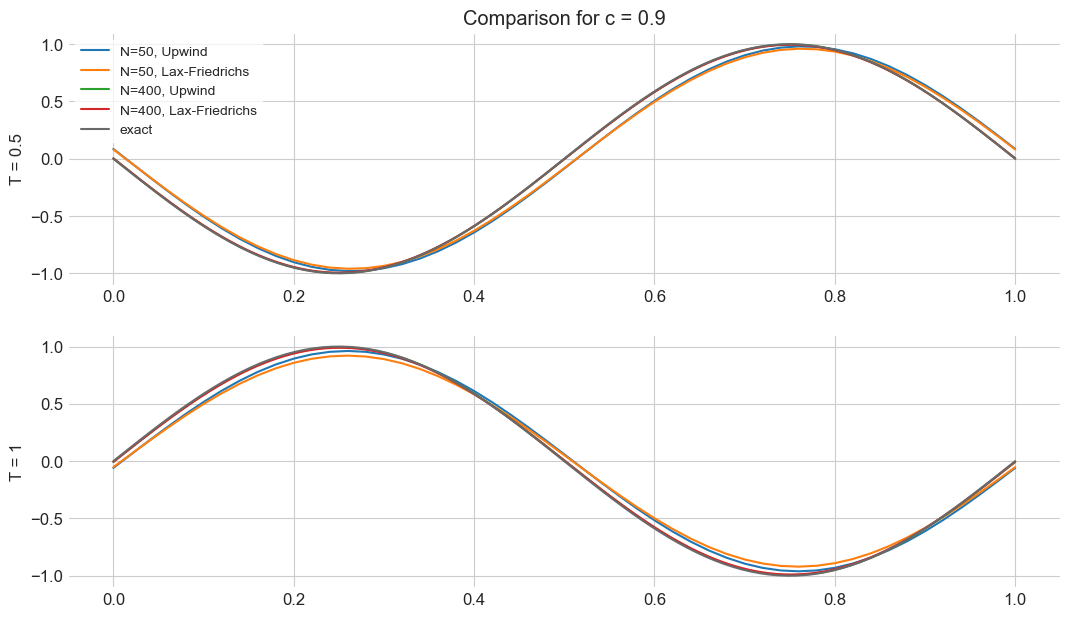

In [5]:
a = -1
D = [0, 1]
Ns = [50, 400]
Ts = [0.5, 1]
c = 0.9  # 0 < c <= 1 to satisfy CFL stability condition

def u0(x):
    return np.sin(2 * np.pi * x)

def exact(x, t):
    return u0(x - a * t)

OUTPUT(a, u0, exact, D, Ns, Ts, c)